---
---

# Customer Retension- Churn Prediction

_USING AZURE MACHINE LEARNING SERVICES TO INCREASE CUSTOMER RETENTION. DEMONSTRATED ON TELECOM CHURN DATASET_


---
---





<img  src="customer.png" width="800"/>



---

# Contents
---
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Analysis](#Analysis)
1. [Training](#Training)
1. [Explanation](#Explanation)
1. [Notes](#Notes)
1. [References](#References)


You will find code (short tutorial) regarding setup,  pandas data manipulation and analysis, training, evaluation and explanation all using azure AutoML package; training, evaluation using traditional methods then explanation using explicit azure explanation package.

---
# Introduction
---

_Churn_ is the activity of customers leaving the services offered by any company or fitness gym. They could leave due to dissatisfaction of the services, or if they moved to a new place, or if their needs changed but the price didn't! There can be many reasons. Now, it would beneficial if there was some kind of survey at the end, when the customer left to understand why they leave, but in most of the cases, there isn't. 

__Aim__- To analyse customer profile data with respect to customer churn, to predict in advance the profiles of customers who are prone to leaving and to understand how to predictive model decided why a customer left or didn't leave. 

__Motivation__- Customer Churn is an interesting problem to solve using data analysis and machine learning. 
Understanding the behaviour of the customers can help in pre-emptively working on keeping them on. All of this can result in saving some potential loss for the company. 


<img src='process.png' />

The above graphic is symbolises the process of analysis for customer retention. First, we collect the data and store it (either on your local machine or on the cloud datastore). Then, we move towards analysing the data, finding interesting trends and understanding the behaviour of the customer. 

Later comes the prediction part. Here we are to construct various models, then evaluate them using different metrics. Finally, we examine the model and it's reasoning for predicting someone to be in the category of churned/not churned.  

---
# Setup
---

All the setup for your development work can be accomplished in a Python notebook. One can perform all the functions on their local computer without accessing the workspace at all. Although here, we would like to take the advantage of the visualizations and logging features that come with accessing and storing in the workspace.

Pre-requisits- To run the notebook you will need:

1. A Python 3.6 notebook server with the following installed:
    The Azure Machine Learning SDK for Python
    matplotlib and scikit-learn
1. The tutorial notebook and the file utils.py
1. A machine learning workspace
1. The configuration file for the workspace in the same directory as the notebook

Check out this website for more details - https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-train-models-with-aml#prerequisites


### Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training


In [1]:
# Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("This notebook was validated with the AzureML SDK version 1.0.18.  You are currently using ", azureml.core.VERSION)

This notebook was validated with the AzureML SDK version 1.0.18.  You are currently using  1.0.18


Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`. The **config.json** file needs to be in the folder of the notebook files. There are multiple ways of generating this config file. You only need to generate this file once for each workspace that you use. 

One of the easiest ways is to go to the azure portal, select the workspace and click on the download config.json file. Your config file contains some important information, so do not publicly post it anywhere.

In [4]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
#print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [6]:
# Create an experiment
from azureml.core import Experiment
from azureml.contrib.explain.model.explanation.explanation_client import ExplanationClient

experiment_name = 'churn2_predict_auto_explain_model'
experiment = Experiment(ws, experiment_name)

run= experiment.start_logging(snapshot_directory=None) # Faster
client = ExplanationClient.from_run(run)

run

Experiment,Id,Type,Status,Details Page,Docs Page
churn2_predict_auto_explain_model,a22bfb98-4e5f-4f51-af62-e0be560b361a,,Running,Link to Azure Portal,Link to Documentation


Here you can see a link to the experiment you just created, onto the Azure Portal. Click on it to see run details. or visualizations that will be added later. 



---
# Data
---

<img src="1.png" width=150 />


The data we are using has these columns -
'customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'

1. Customers who left within the last month – the column is called Churn
1. Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
1. Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
1. Demographic info about customers – gender, age range, and if they have partners and dependents




In [2]:
import pandas as pd

# Reading file into a dataframe
data=pd.read_csv("churn2.csv");

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Columns names
print(list(data.columns))

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [245]:
data.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [244]:
# Here, total Charges should be float, let's change it
data['TotalCharges']=pd.to_numeric(data['TotalCharges'],errors='coerce')

# Analysis

<img src="2.png" width="150" />


For any data science problem, one must first analyse the data. Perform statistical analysis to understand the underlying trends. For example, for any company, important aspects would be to understand their attrition and retention rates. In this example, we don't have date information, so we can't calculate them. 

Although we have a lot of customer profile information and information about the services purchased by the customers. We can get an understanding of which product is most bought, which products are bought together etc.. By having such preliminary analysis, we can bundle services together to increase the profits. 

Below we have created a storyline by asking questions and concluding on the trends and some improvements that can be made by the company.

## 1. Asking Questions

In [141]:
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import math

def roundDown(x):
        return int(math.floor(x / 10.0)) * 10

def roundUp(x):
    return int(math.ceil(x / 10.0)) * 10

def calBinSize(maxx,minn):
    prev_binsize=minn
    temp=max(minn,1)
    for i in range(temp,maxx,5):
        bin_size=i
        if((maxx/i)/temp)>1:
            prev_binsize=bin_size
        else:
            bin_size=prev_binsize
            break

    return bin_size


def getDist(data,column,name):
        '''
        This function displays and plots the histogram of a given column and what the count column should be named
        Input- 
        data:   Datatype- Dataframe Pandas 
        column: Datatype- string  -contains the name of the column in the dataframe whose histogram is to be generated.
        name:   Datatype- string  -has the name of the resulting groupby column of the histogram

        returns-
        None
        '''

        temp=data.groupby([column]).size().reset_index(name=name)
        return temp



class Plot():
    
    def __init__(self,figsize=None):
        plt.figure(figsize=figsize)
        
        return 

    
    def plotHist(self, data,column,name,label=None):
        '''
        This function displays and plots the histogram of a given column and what the count column should be named
        Input- 
        data:   Datatype- Dataframe Pandas 
        column: Datatype- string  -contains the name of the column in the dataframe whose histogram is to be generated.
        name:   Datatype- string  -has the name of the resulting groupby column of the histogram

        returns-
        None
        '''
        
        
        if(is_numeric_dtype(data[column])):

            bins=10
            binBoundaries = np.linspace(minn,maxx,bins,dtype=int)

            data[column].hist(bins=binBoundaries, alpha=0.7,label=label) 
            
            plt.xlabel(column)
            plt.ylabel(name)
            

        else:
            # If it is a categorical data, then make bar chart
            temp=data.groupby([column]).size().reset_index(name=name)
            plt.bar(temp[column],temp[name], alpha=0.7, label=label)
            
        if(label!= None):
            plt.legend()
            
        

        return plt

    


Q1. People that have monthly charges > $100

In [14]:
data.loc[data['MonthlyCharges'] > 100]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
12,8091-TTVAX,Male,0,Yes,No,58,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,No,Credit card (automatic),100.35,5681.10,No
13,0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes
14,5129-JLPIS,Male,0,No,No,25,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.50,2686.05,No
15,3655-SNQYZ,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),113.25,7895.15,No
17,9959-WOFKT,Male,0,No,Yes,71,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),106.70,7382.25,No
38,5380-WJKOV,Male,0,No,No,34,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.35,3549.25,Yes
57,5067-XJQFU,Male,1,Yes,Yes,66,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,108.45,7076.35,No
59,5954-BDFSG,Female,0,No,No,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),107.50,7853.70,No
60,0434-CSFON,Female,0,Yes,No,47,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.50,4707.10,No


Q2. What is the distribution of any column?

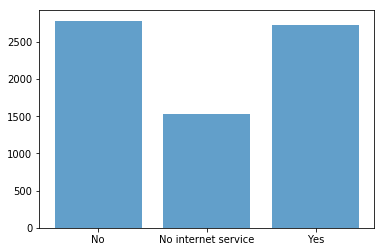

In [142]:
# plotHist is a function defined earlier that takes in a column name and the resulting plot name
plot=Plot()
plt=plot.plotHist(data,'StreamingMovies','Customers')
plt.show()

Q3. How does the distribution differ for customers who have churned and those who have not

In [17]:
churned=data.loc[data['Churn'] =='No']
notchurned=data.loc[data['Churn'] =='Yes']

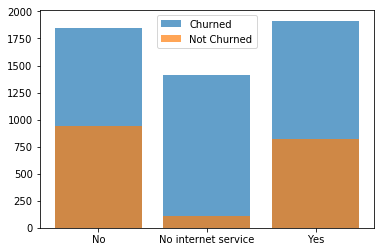

In [143]:
plt=plot.plotHist(churned, 'StreamingMovies','Customers',label='Churned')
plt=plot.plotHist(notchurned, 'StreamingMovies','Customers',label='Not Churned')
plt.show()

This piece of information is useful. We can see that within people who have churned, there are many people who don't have internet access. And once someone gets internet access, it's more likely that they'd stay on. So for people who don't have internet access, the company can give them a trial or some coupons for a few weeks or months. Once they get used to it, they'll keep using it. 
And since there are a lot more people leaving than staying on, this strategy will hopefully increase their customer retention.

Note- there are many. interesting things you can ask when you have the date. Things like customer attrition rate, retention rate. Analysis over time and things like that. But since this dataset doesn't have that, we can't do much.

## 2. Finding trends. Let us find interesting trends automatically in the dataset.
Based on the example given above, we can find interesting insights using KL distribution.
1. Generate distributions for churned customers
1. Generate distributions for not churned customers
1. Calculate KL divergence between them. Higher the KL divergence, the more interesting the trend
1. Fetch top K trends with high KL divergence

In [72]:
from scipy.stats import entropy
import numpy as np
import copy

def calKL(dist1,dist2):
    
    # smoothing for KL divergence- otherwise it goes to inf.
    if(len(dist1)>len(dist2)):
        l=copy.copy(dist1)
        k=copy.copy(dist2)
    else:
        l=copy.copy(dist2)
        k=copy.copy(dist1)
    
    dist1=[]
    dist2=[]
    
    for index in l.keys():
        if(k.get(index,0)):
            dist1.append(l[index])
            dist2.append(k[index])
        else:
            k[index]=0.001
            dist1.append(l[index])
            dist2.append(k[index])
    
        
    kl=entropy(dist1,dist2)
    return kl
    

In [73]:
# removing columns that won't add anything to the analysis stage of the process.
allcolumns=list(data.columns)
# removing customerID
allcolumns.pop(0)
# removing churn
allcolumns.pop(-1)

'Churn'

In [74]:
name='Customers'
KL={}

# Calculating kl divergence for all columns churn and not churn distributions
for column in allcolumns:
    
    temp=getDist(churned,column,name)
    values=temp.values
    dist1={}

    for i in values:
        dist1[i[0]]=i[1]
        
    temp=getDist(notchurned,column,name)
    values=temp.values
    dist2={}

    for i in values:
        dist2[i[0]]=i[1]
    
    kl=calKL(dist1,dist2)
    KL[column]=kl

In [75]:
# Sorting the kl divergence in descending order
sorted_KL= sorted(KL, key=KL.get, reverse=True)

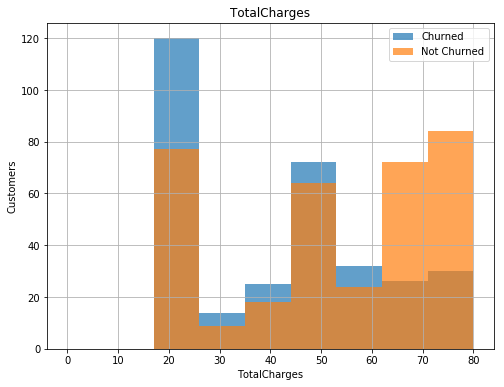

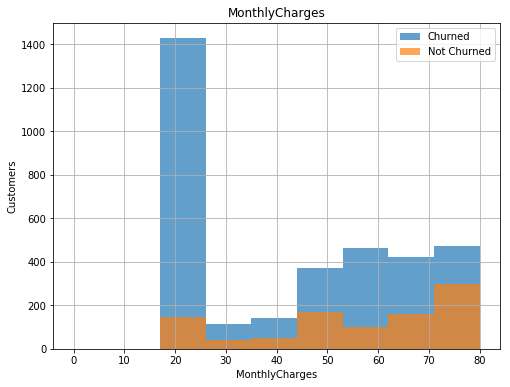

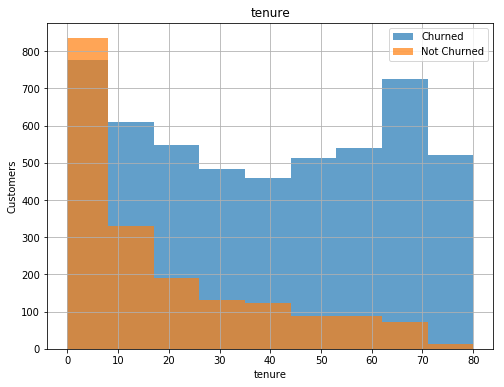

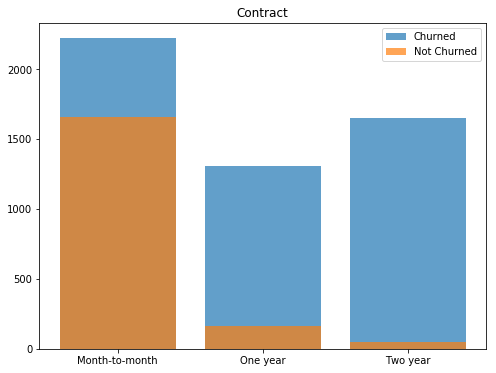

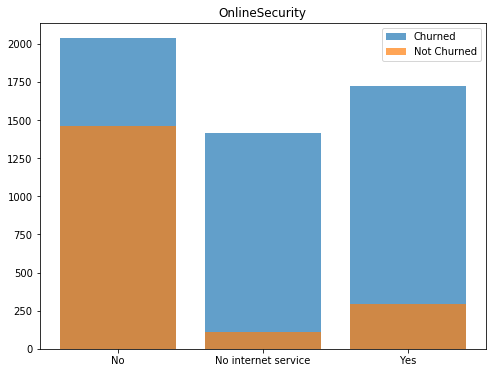

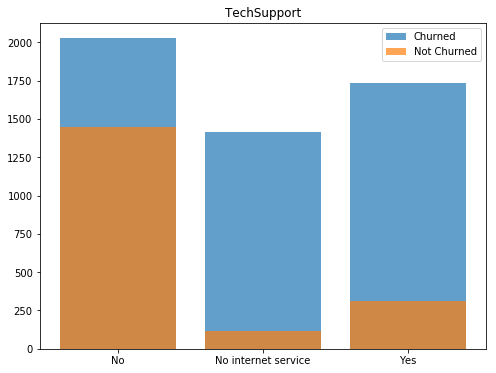

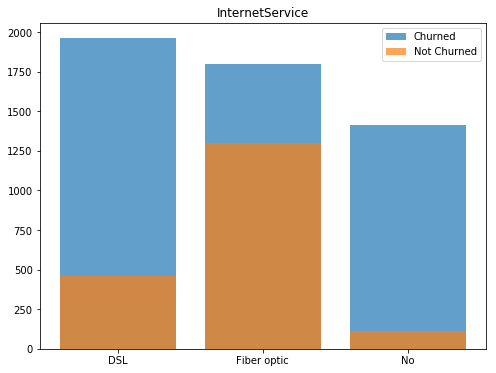

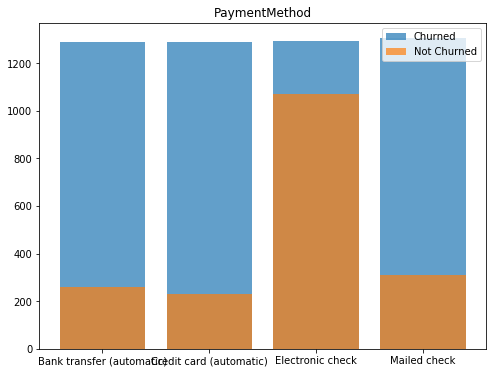

In [144]:
# select top K. Let K=8 then
K=8
name="Customers"
for column in sorted_KL[:K]:
#     print("column is",column)
    
    plot=Plot((8,6))
    plt=plot.plotHist(churned,column,name,label='Churned')
    plt=plot.plotHist(notchurned,column,name,label='Not Churned')
    plt.title(column)
    plt.show()

## 3. Preprocess data for training

In [168]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [231]:
# dropping some columns from the dataset that might not aid in prediction.
data=data.drop(['customerID','InternetService','PaymentMethod'],axis=1)

In [232]:
# Type of contracts
data['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Contract is a categorical variable, meaning it is not numerical. Although since this category of 'time' can be counted, we can replace. Month-to-month by 1, One year by 12, and Two year by 24. 

Understand why this is valid. When we convert a month to 1, year to 12 signifying (12 months), it means that. one year (12) is greater than one month (1)  by a factor of 12, which is true, hence the numbers are able to reciprocate the meaning of the originally categorical variables. Which makes this conversion valid.

In [233]:
data=data.replace('Yes',1)
data=data.replace('No',0)
data=data.replace('No phone service',0)
data=data.replace('No internet service',0)

data['gender']=data['gender'].replace(['Female','female','F','f'], 1)
data['gender']=data['gender'].replace(['Male','male','M','m'], 0)

data['Contract']=data['Contract'].replace(['Month-to-month','One year','Two year'],[1,12,24])


Here, we ought to replace the Yes and No in all the columns by a numerical category.(1/0)

In [234]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,29.85,29.85,0
1,0,0,0,0,34,1,0,1,0,1,0,0,0,12,0,56.95,1889.5,0
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,1,53.85,108.15,1
3,0,0,0,0,45,0,0,1,0,1,1,0,0,12,0,42.30,1840.75,0
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,1,70.70,151.65,1


In [235]:
# Removing the last column, since it is the one that we outght to predict.
all_columns=list(data.columns)
all_columns.pop(-1)

'Churn'

In [246]:
X=data[all_columns]
Y=data['Churn'].values.flatten()

In [273]:
X.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [262]:
#  If there are any missing values, fill it with the mean
X=pd.DataFrame(X).fillna('mean')

In [272]:
# Here, total Charges should be float, let's change it
X['TotalCharges']=pd.to_numeric(X['TotalCharges'],errors='coerce')

---
# TRAINING
_TRAINING AND PREDICTION_

---

<img src= "3.png"  width="200" />


## 1. Training with AutoML
_When training with autoML, you can get the model explanation too. Just set the flag of model_explanability to be True.

In [274]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=223)

In [190]:
import logging
from azureml.train.automl import AutoMLConfig

The AutoMLConfig object defines the settings and data for an AutoML training job. Here, we set necessary inputs like the task type, the number of AutoML iterations to try, and the training and validation data.
AutoML will currently train a classification-type model for a given training set. 


|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**max_time_sec**|Time limit in minutes for each iterations|
|**iterations**|Number of iterations. In each iteration Auto ML trains the data with a specific pipeline|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification.  This should be an array of integers. |
|**X_valid**|(sparse) array-like, shape = [n_samples, n_features]|
|**y_valid**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]|
|**model_explainability**|Indicate to explain each trained pipeline or not |
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. |

Now, you can do all of preprocessing before the training stage, or just set the flag of 'preprocess' in the AutoMLConfig as True and all the preprocessing will be taken care of. Although, it is highly likely that the Contract column will be treated as a categorical varible after preprocessing as well, instead of the integer transformation that we had made.

Now, here we have merged the training and explanation process using the autoML package. So, for that we need to provide validation sets for the explanation since it doesn't support cross validation. 
If you are not interested in model explanation and want cross validation, just use the parameter n_cross_validations = K, for K fold cross validation.

Also, since the Y data is a series, we need to flatten the Y data before inputting it into  the AutoML config.

In [225]:
project_folder='/Users/deeksharazdan/AzNotebooks/Experiments_Deeksha/churn/Telecom'
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'average_precision_score_weighted',
                             iteration_timeout_minutes = 60,
                             iterations = 10,
                             verbosity = logging.INFO,
                             X = x_train, 
                             y = y_train.values.flatten(),
                             path = project_folder,
                             preprocess = True,
                             model_explainability=True,
                             X_valid = x_test,
                             y_valid = y_test.values.flatten()
                            )


You can now submit a new training run. For local runs, the execution is synchronous. Depending on the data and number of iterations this operation may take several minutes.
Information from each iteration will be printed to the console

In [226]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_f8ca63d9-c8b1-4186-8512-50c6165aa44d
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   MaxAbsScaler LightGBM                          100.0000    0:07:42       0.6672    0.6672
         1   MaxAbsScaler LightGBM                          100.0000    0:00:08       0.6672    0.6672
         2   MaxAbsScaler LightGBM                          100

The issue with this is that it takes a lot of time.

In [198]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

### Retrieve the Best Model
Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. We can now retrieve the pipeline with the best performance on the validation dataset:

In [199]:
best_run, fitted_model = local_run.get_output()

In [209]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, ypred)  

### Best Model 's explanation

Retrieve the explanation from the best_run. And explanation information includes:

1.	shap_values: The explanation information generated by shap lib
2.	expected_values: The expected value of the model applied to set of X_train data.
3.	overall_summary: The model level feature importance values sorted in descending order
4.	overall_imp: The feature names sorted in the same order as in overall_summary
5.	per_class_summary: The class level feature importance values sorted in descending order. Only available for the classification case
6.	per_class_imp: The feature names sorted in the same order as in per_class_summary. Only available for the classification case

In [ ]:
from azureml.train.automl.automlexplainer import retrieve_model_explanation

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
    retrieve_model_explanation(best_run)

In [ ]:
print(overall_summary)
print(overall_imp)

In [ ]:
print(per_class_summary)
print(per_class_imp)

In [ ]:
Beside retrieve the existed model explanation information, explain the model with different train/test data

In [ ]:
from azureml.train.automl.automlexplainer import explain_model

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
    explain_model(fitted_model, X_train, X_test)

In [ ]:
print(overall_summary)
print(overall_imp)

## 2. General Training process 
_TRAINING WITHOUT AUTOML_

<img src= "4.png"  width="100" />


In one of the papers that had a similar dataset on Telecom churn, it concluded with Random forest working the best- https://thesai.org/Downloads/Volume9No2/Paper_38-Machine_Learning_Techniques_for_Customer_Retention.pdf

Considering that the output of random forests is the majority vote by a large number of independent decision trees and each tree is naturally interpretable.

The global feature importance of random forests can be quantified by the total decrease in node impurity averaged over all trees of the ensemble (“mean decrease impurity”).

For one instance, because the decision paths in all the trees are well tracked, we can use the difference between the mean value of data points in a parent node between that of a child node to approximate the contribution of this split. 

In [229]:
from sklearn.ensemble import RandomForestClassifier

In [276]:
# Here we will require preprocessed data.
rf_clf = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf_clf.fit(x_train, y_train)
rf_pred_test = rf_clf.predict(x_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [275]:
x_train.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.values.flatten(), rf_pred_test)

---
# Explanation
---

<img src= "5.png"  width="150" />

This classification (global/local explanation) of interpretation means whether the interpretation method explains a single prediction or the entire model behavior. To comprehend and interpret the whole model at once, we need global interpretability.

Global- How does the model make predictions? How do subsets of the model influence model decisions? Trying to understand feature interactions and importances is always a good step towards understanding global interpretation. 

Of course, visualizing features after more than two or three dimensions becomes quite difficult when trying to analyze interactions. 




In [200]:
import azureml.core
from azureml.core import Workspace, Experiment, Run
from azureml.contrib.explain.model.tabular_explainer import TabularExplainer
from azureml.contrib.explain.model.explanation.explanation_client import ExplanationClient

To address different sophistication levels and needs of the users, the SDK introduces two sets of explainers, Meta Explainers and Direct Explainers.

Direct Explainers are the explainers coming straight from the integrated libraries such as SHAP, LIME, etc.. The MLI SDK wraps all the explainers so they have a common API and output format, but otherwise provides them to users without major changes. Data scientists can invoke a Direct Explainer if they have good knowledge of the explainer and prefer to call it directly, either because they know which one they would like to use or because they would like to evaluate performance of individual explanation methods.

`TabularExplainer`, `TextExplainer` and `ImageExplainer` are the Meta Explainers, which automatically select a suitable direct explainer and generate the best explanation info based on the given model and data sets. `TabularExplainer`, `TextExplainer` and `ImageExplainer` should be called on tabular, text and image datasets respectively.  The Meta Explainers leverage all the libraries (SHAP, LIME, GA2M, Mimic, etc.) that we have integrated or developed.

In [202]:
tabular_explainer = TabularExplainer(fitted_model, x_train)

ValueError: Could not find valid explainer to explain model

Typically, a feature’s importance is the increase in the model’s prediction error after we permuted the feature’s values. However, frameworks like SHAP, use a combination of feature contributions and game theory to come up with SHAP values. Then, it computes the global feature importance by taking the average of the SHAP value magnitudes across the dataset. 

The permutation feature importance measurement was introduced for Random Forests by Breiman (2001). Based on this idea, Fisher, Rudin, and Dominici (2018) proposed a model-agnostic version of the feature importance — they called it Model Reliance.

## 1. Global explanation

In [ ]:
explanation = tabular_explainer.explain_global(x_test)

Once uploaded you can view the explanation in the portal

In [ ]:
# uploading the explanation to the cloud. One can visualize the explanation there.
client.upload_model_explanation(explanation)

<img src='viz.png' width="500" />

When you pass nothing in the paranthesis of this function, it returns all the features already ranked as per its importance, or else you can specify a value to fetch top- K important features, and their values.


In [ ]:
global_importance_values = explanation.get_ranked_global_values()
global_importance_names = explanation.get_ranked_global_names()

## 2. Explain individual instance predictions (local explanation) 


Local- Why did the model make specific decisions for a single instance? and Why did the model make specific decisions for a group of instances? For local interpretability, we do not care about the inherent structure or assumptions of a model and we treat it as a black box. 

For understanding prediction decisions for a single datapoint, we focus specifically on that datapoint and look at a local subregion in our feature space around that point, and try to understand model decisions for that point based on this local region. 

In [ ]:
# you can directly get local importance values for all test data by this code
explanation = tabular_explainer.explain_local(x_test)

# Although, if you like to go one sample at a time, you can use this code-
# since x_test is a df. use - x_test.values[0], else use x_test[0]
local_explanation = tabular_explainer.explain_local(x_test.values[0])

In [ ]:
# local feature importance information- Since given <x_test[0,:]> as input, only that sample's local imp is shown.
local_importance_values = local_explanation.local_importance_values

In [215]:
# complete the run that we started in the beginning
run.complete()

--------------------------------------------------------------------------------------------------------------------

# Notes

--------------------------------------------------------------------------------------------------------------------

1. Any models that are trained on datasets in Python numpy.array, pandas.DataFrame, iml.datatypes.DenseData or scipy.sparse.csr_matrix format are supported by the MLI SDK.
1. The explanation functions accept both models and pipelines as input. If a model is provided, the model is expected to have implemented the prediction function "predict" or "predict_proba" that confirms to the Scikit convention. 
1. You might come across some errors related explanation and automl in the azure code files. Check the version of the packages and update them using this command

pip install --upgrade azureml-sdk[explain,automl] pip install --upgrade azureml-sdk[notebooks

# References

Data
https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/

Blogs
1. https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
1. https://datascienceplus.com/predict-customer-churn-logistic-regression-decision-tree-and-random-forest/
1. https://shirinsplayground.netlify.com/2018/12/customer_churn_code/

Kaggle 
https://www.kaggle.com/blastchar/telco-customer-churn

Paper
https://www.irjet.net/archives/V3/i4/IRJET-V3I4213.pdf